In [24]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [57]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [58]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [59]:
metric = "adc"
distribution_metric = "qfmean"
data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)

/tmp/ipykernel_200180/1959349132.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [60]:
metric_col = "volume" if metric == "gm_vol" else distribution_metric

In [61]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [63]:
from tqdm import tqdm
# Set up dataframes to store results

models = {}

for save_name in ["lin_unw", "lin_w", "quad_unw", "quad_w", "unw_compare", "w_compare"]:
    models[save_name] = pd.read_pickle(OUTPUT_DIR.with_name("fig2") / f"{save_name}_{metric}.pkl")



In [113]:
# Tell the pipeline which side of the parabola is “structural stabilisation”
orientation = {           # feel free to expand
    "gm_vol" : "max",      # concave-down expected
    "adc"    : "min",      # concave-up expected
    # "fa"   : "min",
    # "rd"   : "min",
}

def vertex_age(beta1, beta2):
    """Age at vertex of a quadratic   β0 + β1·x + β2·x²."""
    return -beta1 / (2 * beta2)

def stabilisation_age(metric, betas, *, age_min=18, age_max=85):
    """
    betas = dict with keys "age" (β1) and "age_sq" (β2)
    Returns (age*, flagged)   where flagged=True if outside range or wrong shape.
    """
    want = orientation.get(metric, "min")       # default = 'min' if not listed
    β1, β2 = betas["age"], betas["age_sq"]

    # ── 1. Shape check  ────────────────────────────────────────────────
    if   want == "min" and β2 <= 0:
        # parabola opens down – no minimum inside; flag & push to boundary
        return age_min, True
    elif want == "max" and β2 >= 0:
        # parabola opens up – no maximum inside
        return age_max, True

    # ── 2. Compute vertex  ─────────────────────────────────────────────
    age_star = vertex_age(β1, β2)
    clipped  = False

    # clip to observed age window
    if age_star < age_min:
        age_star, clipped = age_min, True
    elif age_star > age_max:
        age_star, clipped = age_max, True

    return age_star, clipped


In [114]:
alpha = 0.05
use_quad = models["w_compare"]["p_corrected"] < 0.001

stab_df = parcels.copy()

age_min = np.nan

for i, row in parcels.iterrows():
    lm = models["lin_w"].loc[i,"model"]
    qm = models["quad_w"].loc[i,"model"]
    p = models["w_compare"].loc[i,"p_corrected"]
    if p < alpha and qm.params["age_squared"] != 0:
        β1 = qm.params["age_at_scan"]
        β2 = qm.params["age_squared"]
        age_star, clipped = stabilisation_age(metric, {"age": β1, "age_sq": β2})
        chosen = "quadratic"
    else:
        age_star = age_min                     # or age_max / np.nan
        clipped   = False
        chosen    = "linear"

    
    # Save the results
    stab_df.loc[i, "age_star"] = age_star
    stab_df.loc[i, "clipped"] = clipped
    stab_df.loc[i, "chosen"] = chosen
    stab_df.loc[i, "p"] = p
    stab_df.loc[i, "β1"] = β1 if chosen=="quadratic" else lm.params["age_at_scan"]
    stab_df.loc[i, "β2"] = β2 if chosen=="quadratic" else 0.0
    stab_df.loc[i, "r2_lin"] = lm.rsquared_adj
    stab_df.loc[i, "r2_quad"] = qm.rsquared_adj

In [ ]:
i = 65
lm = models["lin_w"].loc[i,"model"]
qm = models["quad_w"].loc[i,"model"]
p = models["w_compare"].loc[i,"p_corrected"]
if p < alpha and qm.params["age_squared"] != 0:
    β1 = qm.params["age_at_scan"]
    β2 = qm.params["age_squared"]
    age_star, clipped = stabilisation_age(β1, β2, metric)
    chosen = "quadratic"
else:
    age_star = age_min                     # or age_max / np.nan
    clipped   = False
    chosen    = "linear"

In [109]:
controls = ["sex"]
if metric == "gm_vol":
    controls += ["tiv"]
age_max = 100

age_grid = np.linspace(18, age_max, 300)
pred_df  = pd.DataFrame({ "age_at_scan": age_grid })
pred_df["age_squared"] = pred_df["age_at_scan"]**2
# pred_df = data[data[region_col] == parcels.loc[i,region_col]].copy()

for cov in controls:
    if data[cov].dtype.kind in "bifc":      # numeric
        pred_df[cov] = data[cov].median()
    else:                                          # categorical
        pred_df[cov] = data[cov].mode()[0]
pred_df["sex"] = pred_df["sex"].map({"F": 1, "M": 0})
# get predictions
pred_df["pred"] = qm.predict(pred_df)
# # qm.summary()

In [115]:
stab_df.sort_values("age_star", ascending=False)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
413,414,PUT-DA-rh,PUT-DA,"Putamen, dorso-anterior part",subcortex,Putamen,R,55.957622,False,quadratic,4.046007e-16,-2.961982e-06,2.646630e-08,0.030586,0.062170
412,413,PUT-VA-rh,PUT-VA,"Putamen, ventro-anterior part",subcortex,Putamen,R,55.595896,False,quadratic,2.033628e-22,-2.298223e-06,2.066899e-08,0.036254,0.081041
118,119,7Networks_LH_Limbic_TempPole_1,7networks_lh_limbic_temppole,7Networks_LH_Limbic_TempPole,limbic,temporal pole,L,55.431994,False,quadratic,4.252251e-02,-7.506675e-07,6.771067e-09,0.002744,0.004384
415,416,PUT-DP-rh,PUT-DP,"Putamen, dorso-posterior part",subcortex,Putamen,R,54.103076,False,quadratic,8.907058e-18,-3.349901e-06,3.095851e-08,0.036461,0.071393
426,427,aGP-rh,aGP,"Pallidum, anterior part",subcortex,Pallidum,R,53.842908,False,quadratic,1.901007e-08,-4.424240e-06,4.108471e-08,0.009714,0.025075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,334,7Networks_RH_Cont_Par_3,7networks_rh_cont_par,7Networks_RH_Cont_Par,control,parietal,R,NaN,False,linear,7.043816e-01,3.586742e-06,0.000000e+00,0.196837,0.196498
334,335,7Networks_RH_Cont_Par_4,7networks_rh_cont_par,7Networks_RH_Cont_Par,control,parietal,R,NaN,False,linear,5.303450e-01,9.305420e-07,0.000000e+00,0.046696,0.046424
374,375,7Networks_RH_Default_PFCv_1,7networks_rh_default_pfcv,7Networks_RH_Default_PFCv,default,ventral prefrontal cortex,R,NaN,False,linear,6.174414e-01,3.727954e-07,0.000000e+00,0.010698,0.010337
390,391,7Networks_RH_Default_PFCdPFCm_13,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,NaN,False,linear,5.433786e-01,2.232753e-07,0.000000e+00,0.004604,0.004307


In [123]:
stab_df.sort_values("age_star", ascending=True)

,index,name,base_name,Label Name,network,component,hemisphere,age_star,clipped,chosen,p,β1,β2,r2_lin,r2_quad
410,411,THA-DAm-rh,THA-DAm,"Thalamus, medial dorso-anterior part",subcortex,Thalamus,R,18.0,True,quadratic,5.050554e-24,-3.648704e-06,1.061386e-07,0.357799,0.389904
360,361,7Networks_RH_Cont_PFCmp_2,7networks_rh_cont_pfcmp,7Networks_RH_Cont_PFCmp,control,medial posterior prefrontal cortex,R,18.0,True,quadratic,3.631131e-29,7.956107e-06,-7.881683e-08,0.008472,0.069141
6,7,7Networks_LH_Vis_7,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,3.112730e-02,1.025358e-06,1.384146e-08,0.170877,0.172469
10,11,7Networks_LH_Vis_11,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,1.031275e-22,-1.898130e-06,5.457597e-08,0.341646,0.372668
11,12,7Networks_LH_Vis_12,7networks_lh_vis,7Networks_LH_Vis,visual,visual,L,18.0,True,quadratic,6.615524e-07,-4.079144e-07,1.854276e-08,0.166182,0.176241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,334,7Networks_RH_Cont_Par_3,7networks_rh_cont_par,7Networks_RH_Cont_Par,control,parietal,R,NaN,False,linear,7.043816e-01,3.586742e-06,0.000000e+00,0.196837,0.196498
334,335,7Networks_RH_Cont_Par_4,7networks_rh_cont_par,7Networks_RH_Cont_Par,control,parietal,R,NaN,False,linear,5.303450e-01,9.305420e-07,0.000000e+00,0.046696,0.046424
374,375,7Networks_RH_Default_PFCv_1,7networks_rh_default_pfcv,7Networks_RH_Default_PFCv,default,ventral prefrontal cortex,R,NaN,False,linear,6.174414e-01,3.727954e-07,0.000000e+00,0.010698,0.010337
390,391,7Networks_RH_Default_PFCdPFCm_13,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,NaN,False,linear,5.433786e-01,2.232753e-07,0.000000e+00,0.004604,0.004307


/tmp/ipykernel_200180/289078991.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


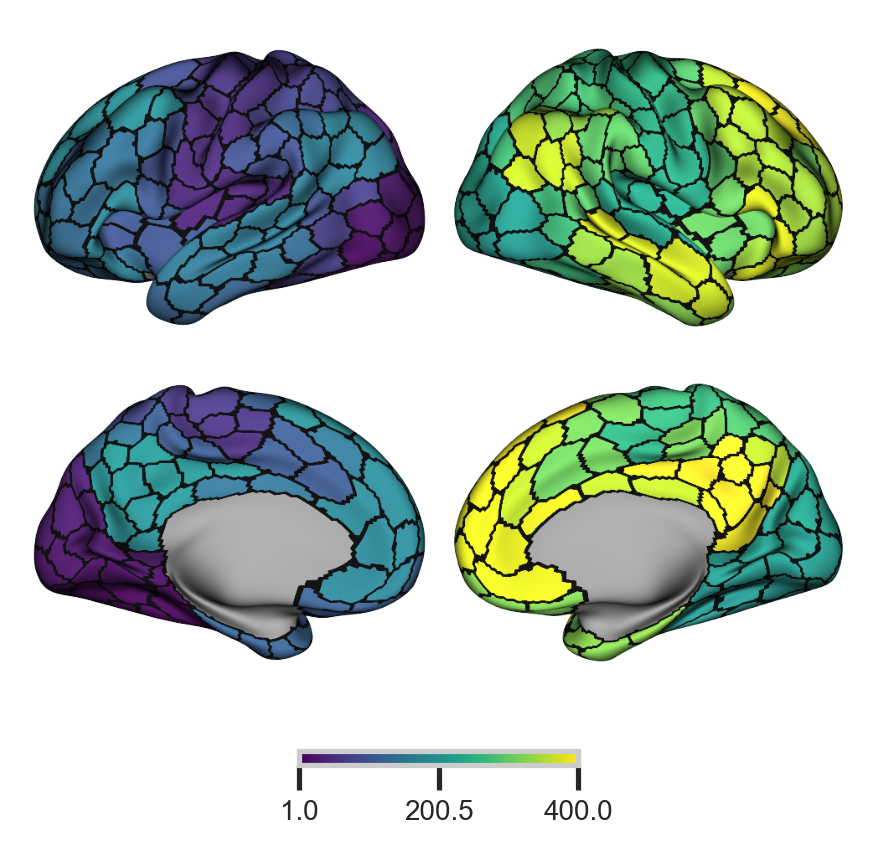

In [116]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
p = Plot(lh, rh)

# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation('schaefer')
p.add_layer({'left': lh_parc, 'right': rh_parc}, cbar=True)

p.add_layer({'left': lh_parc, 'right': rh_parc}, cmap='gray',
            as_outline=True, cbar=False)
fig = p.build()
fig.show()

In [117]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [118]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region":[],"value":[],"Hemisphere":[]}

vis_df = stab_df
value_column = "age_star"

for i, row in vis_df.iterrows():
    label = row[region_col]
    value = row[value_column]
    # if (row["p_corrected"] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
    # else:
    #     value = np.nan
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            value_map[label] = value

vec = np.vectorize(lambda x: value_map.get(x, np.nan))
data_lh = vec(lh_parc)
data_rh = vec(rh_parc)

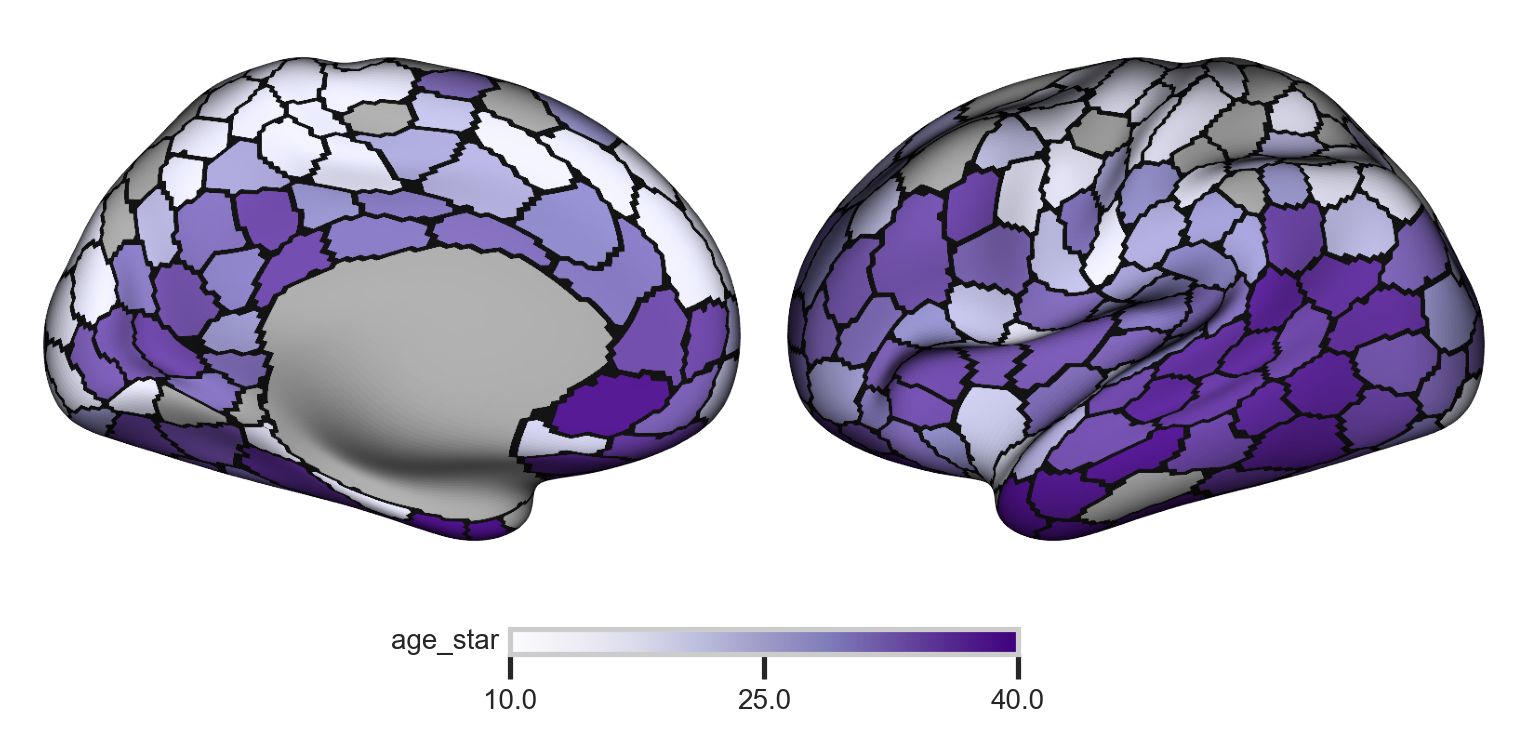

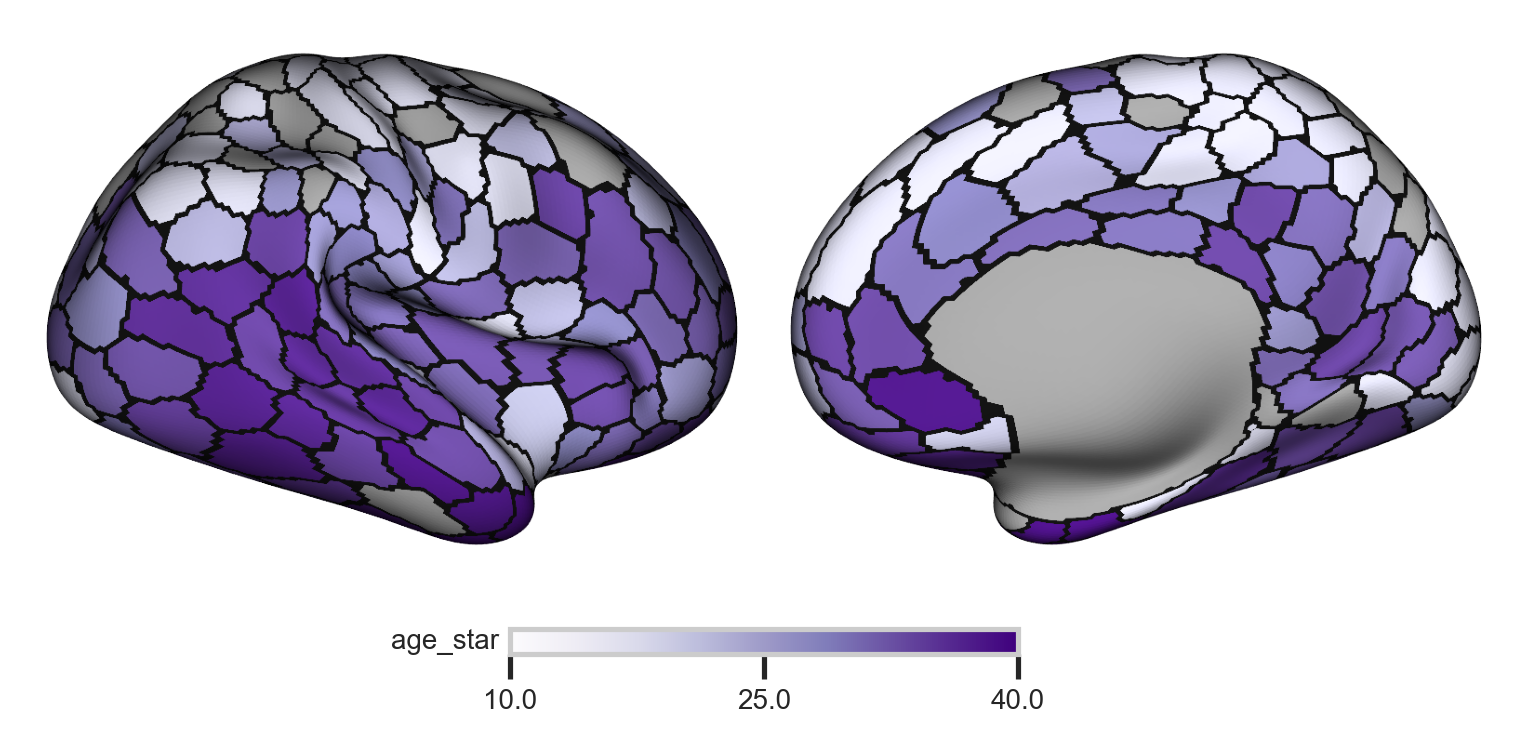

In [125]:
vmin = 10
vmax = 40

for hemi, hemi_data, key, vis_data in zip(["L","R"],[lh,rh], ["left","right"], [data_lh, data_rh]):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    p = Plot(
        hemi_data,
        # rh,
        # views="latmed",  # L-lat, L-med, R-lat, R-med
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",
        mirror_views=True,
        views=["medial","lateral"]
    )

    # ---- main data layer -------------------------------------------------
    # If your metric is centred on 0 (e.g., t-values) use TwoSlopeNorm for symmetry
    # norm = TwoSlopeNorm(
    #     vmin=np.nanmin([data_lh, data_rh]), ,vmax=np.nanmax([data_lh, data_rh])
    # )

    p.add_layer(
        {"left": data_lh, "right": data_rh},
        cmap="Purples",
        color_range=(vmin,vmax),
        # color_range=(2.5,3.5),
        cbar_label=value_column,
    )
    # ---- outline layer ---------------------------------------------------
    # Re-use the label arrays; surfplot draws borders when as_outline=True
    p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)


    # fig = p.build(cbar_kws=dict(location="bottom", decimals=2))
    fig = p.build()

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig3_{metric}_{hemi}_{value_column}.png", dpi=400)

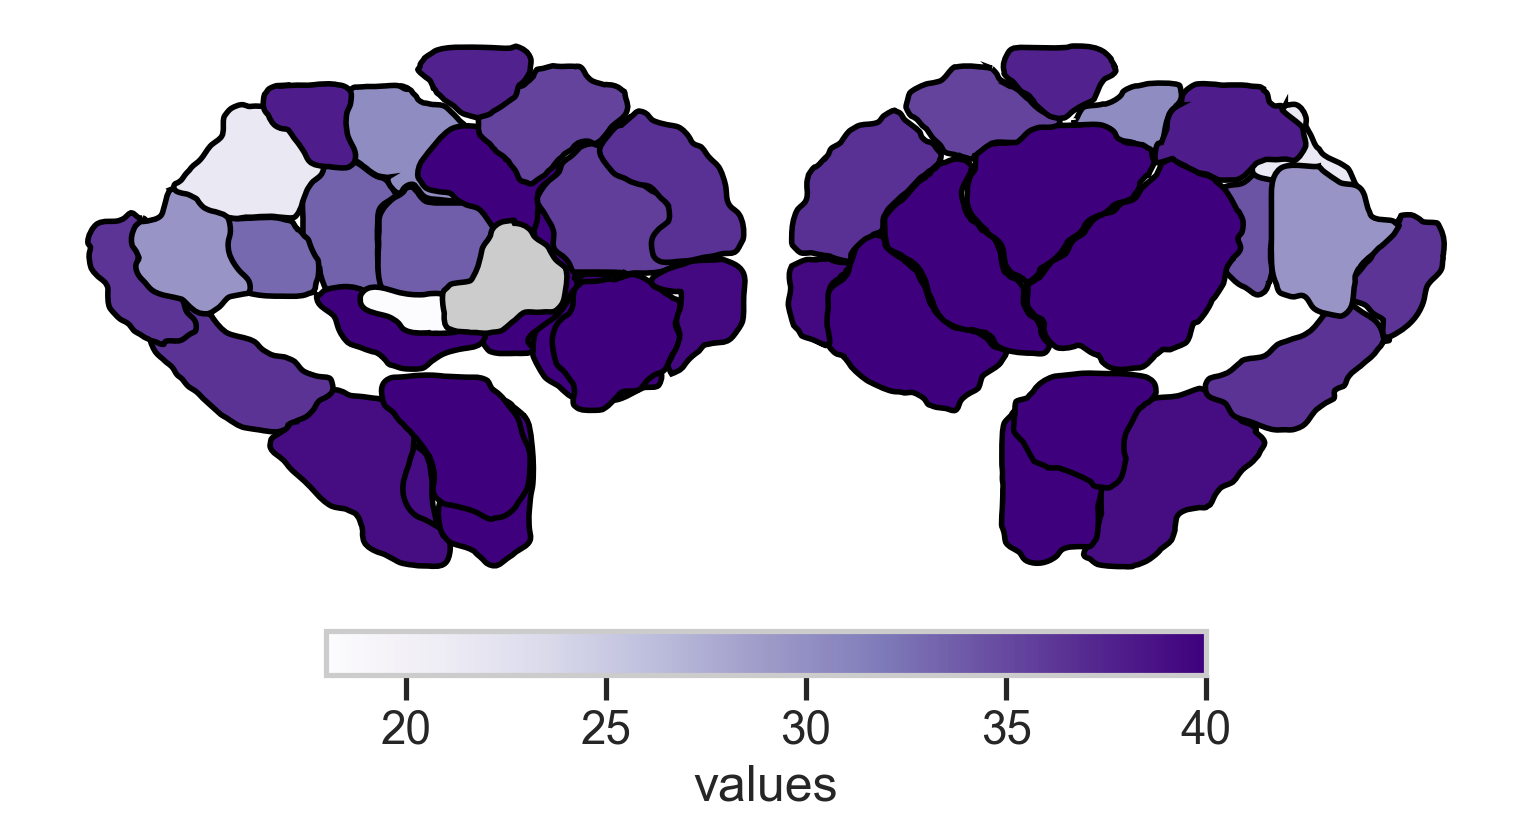

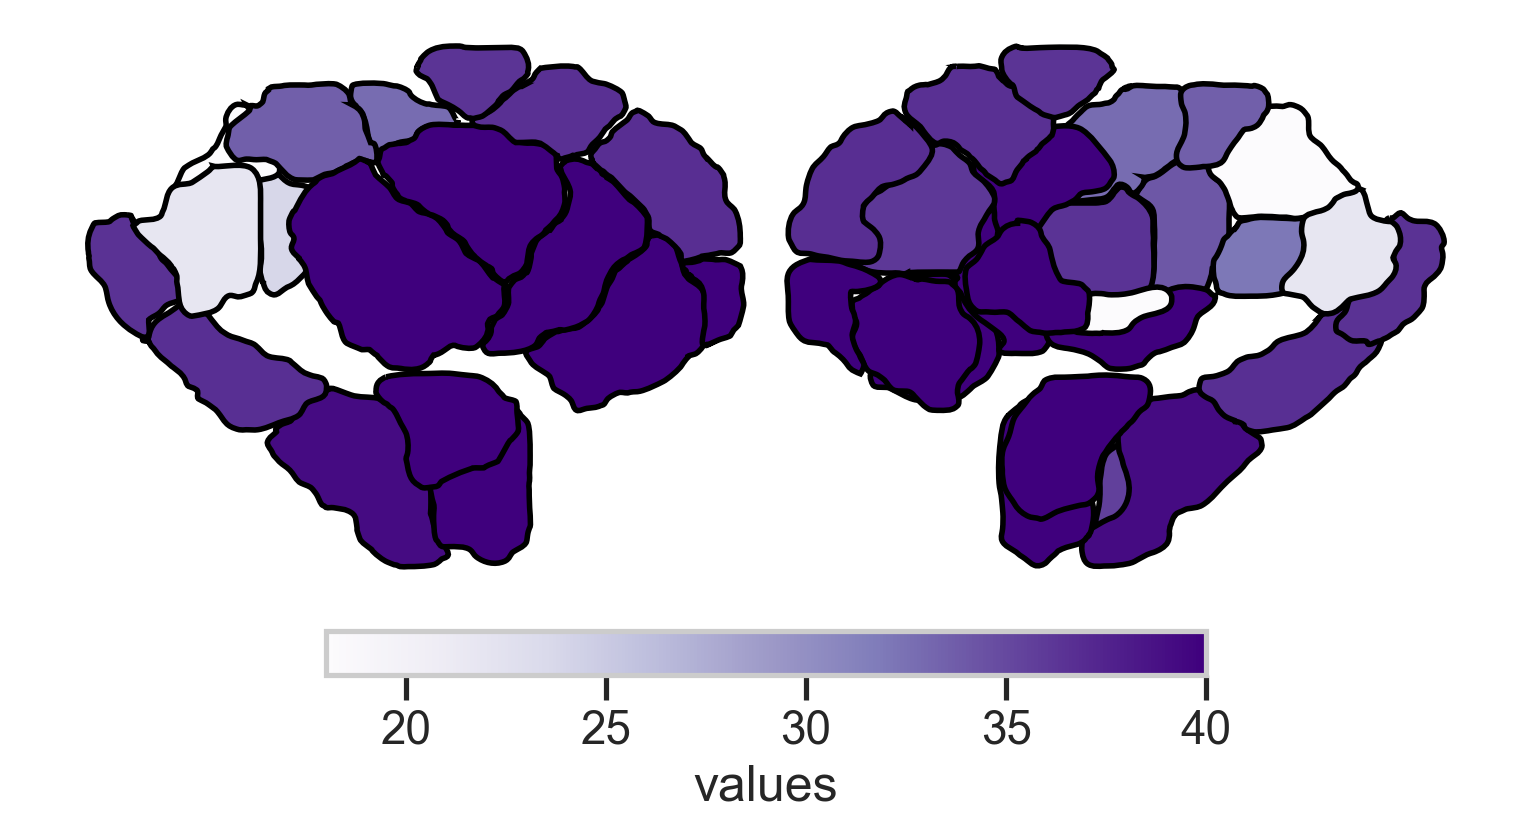

In [120]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L","R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="Purples",
        line_color="black",
        line_thickness=2,
        vmin = vmin,
        vmax = vmax,
        show_figure=False
    )

    # save figure
    savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)
